<a href="https://colab.research.google.com/github/gandhimonil9823/Covid_Stock_Analysis/blob/main/Covid_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import statistics 
import numpy as np
from mpl_toolkits.basemap import Basemap
%matplotlib inline
import pathpy as pp
from geopy import distance
from geopy.distance import geodesic
import itertools

In [ ]:
# !apt-get install -q libgeos-3.5.0
# !apt-get install -q libgeos-dev
# !pip install -q https://github.com/matplotlib/basemap/archive/master.zip

In [ ]:
# !pip install -q pyproj==1.9.6

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Merging the Stock Indexes and the currency data with rows as dates and columns as index values
# Preprocessing the data sets with online steps for data processing 
# Figuring a way to convert the unemployment data into county wise data - probably using a probability distribution
# Deal with missing stock data for weekends and holidays

Stock Data: Pre-processing


In [26]:
# Reading CSVs for three stock indices
df = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/DJI.csv")
df_DJI = df[["Date", "Adj Close", "Volume"]]

df = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/NASDAQ.csv")
df_NASDAQ = df[["Date", "Adj Close", "Volume"]]

df = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/S&P500.csv")
df_SP500 = df[["Date", "Adj Close", "Volume"]]

df_covid_clean_complete = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/COVID_19/covid_19_clean_complete.csv")

df_centroid = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/COVID_19/pre_processed_centroid.csv")




In [4]:
# Rename columns in each index in order to merge the indices 
df_NASDAQ = df_NASDAQ.rename(columns={'Adj Close': 'Adj_Close_NASDAQ', 'Volume': 'Volume_NASDAQ'})
df_SP500 = df_SP500.rename(columns={'Adj Close': 'Adj_Close_SP500', 'Volume': 'Volume_SP500'})
df_DJI = df_DJI.rename(columns={'Adj Close': 'Adj_Close_DJI', 'Volume': 'Volume_DJI'})

In [5]:
# Merging data of three stock indices based on column: 'Date' (merging two DFs at once)
df_Merged = pd.merge(df_SP500, df_DJI, on=['Date'])
df_stock_data = pd.merge(df_Merged, df_NASDAQ, on=['Date'])

In [6]:
df_stock_data.head()

,Date,Adj_Close_SP500,Volume_SP500,Adj_Close_DJI,Volume_DJI,Adj_Close_NASDAQ,Volume_NASDAQ
0,2015-10-26,2071.179932,3385800000,17623.050781,116660000,5034.700195,1758690000
1,2015-10-27,2065.889893,4216880000,17581.429688,113960000,5030.149902,1986840000
2,2015-10-28,2090.350098,4698110000,17779.519531,115630000,5095.689941,2141130000
3,2015-10-29,2089.409912,4008940000,17755.800781,90300000,5074.270020,1928310000
4,2015-10-30,2079.360107,4256200000,17663.539063,149250000,5053.750000,2016390000


In [7]:
df_stock_data.shape

(1259, 7)

In [8]:
df_with_missing = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/stock_closing_prices_188.csv")
df_with_missing

,Date,Adj_Close_SP500,Adj_Close_DJI,Adj_Close_NASDAQ
0,2020-01-22,3321.750000,29186.26953,9383.769531
1,2020-01-23,3325.540039,29160.08984,9402.480469
2,2020-01-24,3295.469971,28989.73047,9314.910156
3,2020-01-25,3278.098532,28837.62388,9256.004910
4,2020-01-26,3260.818664,28686.31538,9197.472167
...,...,...,...,...
183,2020-07-23,3235.659912,26652.33008,10461.419920
184,2020-07-24,3215.629883,26469.89063,10363.179690
185,2020-07-25,3223.537100,26508.12833,10420.558030
186,2020-07-26,3231.463760,26546.42127,10478.254050


# COVID-19 Data Loading and Preprocessing

In [9]:
# Function to load the covid_clean_complete dataset from the drive
def load_dataset_us_cases():  
  df_covid_clean_complete = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/COVID_19/covid_19_clean_complete.csv")
  return df_covid_clean_complete

# Function to preprocess the clean_complete_dataset
def preprocess_us_cases_df():
  df_US_daily_cases = load_dataset_us_cases()

  # get the daily data only for US
  df_US_daily_cases = df_covid_clean_complete.loc[df_covid_clean_complete['Country/Region'] == "US"]
  
  df_US_daily_cases = df_US_daily_cases.reset_index(drop=True)

  # Added a column for new_cases daily by getting the differerence of the confirmed cases
  df_US_daily_cases["New_cases"] = df_US_daily_cases["Confirmed"].diff()
  
  df_US_daily_cases['New_cases'] = df_US_daily_cases['New_cases'].fillna(0)

  df_US_daily_cases = df_US_daily_cases.rename(columns={"Confirmed": "Total_Confirmed", "Deaths" : "Total_Deaths"})

  return df_US_daily_cases


# Standardize the COVID variables like New_cases, Total_cases, Total_deaths

In [10]:
# Function to standardize the covid_variables like New_cases, Total_cases, Total_deaths
# Adds new columns to the df with the standarized values
# params - the dataframe, and the column name (COVID Variable) which has to be standarized
def covid_variable_impact_cal(dataframe_to_standardize, column_name):
  # col_mean = dataframe_to_standardize[column_name].mean()
  # col_std  = dataframe_to_standardize[column_name].std()

  col_name = "Standardized_Value_" + column_name
  dataframe_to_standardize[col_name] = dataframe_to_standardize[column_name]

  i = 0
  j = 0
  while i < len(dataframe_to_standardize):
    j = i
    if i > 7:
      col_mean = dataframe_to_standardize[column_name][j - 8: j - 1].mean()
      col_std  = statistics.stdev(dataframe_to_standardize[column_name][j - 8: j - 1])

      curr_daily_value = dataframe_to_standardize[column_name][i]

      formula_cal_value = (curr_daily_value - col_mean) / col_std

      dataframe_to_standardize.loc[i, col_name] = formula_cal_value

    i += 1
  dataframe_to_standardize[col_name].replace(np.inf, 0, inplace=True)
  return dataframe_to_standardize

In [11]:
df_US_daily_cases = preprocess_us_cases_df()
df_US_daily_cases.head()



,Province/State,Country/Region,Lat,Long,Date,Total_Confirmed,Total_Deaths,Recovered,Active,WHO Region,New_cases
0,NaN,US,40.0,-100.0,2020-01-22,1,0,0,1,Americas,0.0
1,NaN,US,40.0,-100.0,2020-01-23,1,0,0,1,Americas,0.0
2,NaN,US,40.0,-100.0,2020-01-24,2,0,0,2,Americas,1.0
3,NaN,US,40.0,-100.0,2020-01-25,2,0,0,2,Americas,0.0
4,NaN,US,40.0,-100.0,2020-01-26,5,0,0,5,Americas,3.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


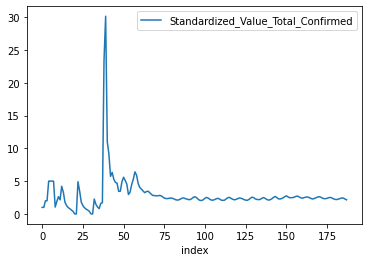

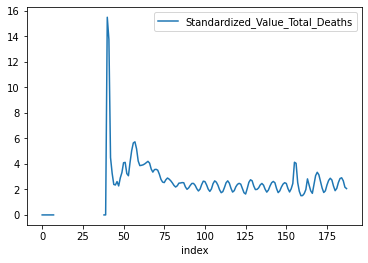

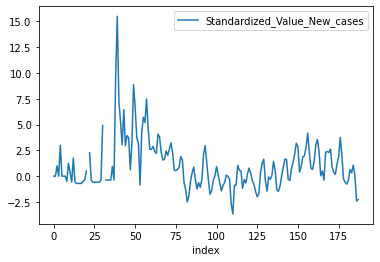

In [12]:
df_standarized_total_confirmed = covid_variable_impact_cal(df_US_daily_cases, "Total_Confirmed")

df_standarized_total_confirmed.reset_index().plot(x='index', y='Standardized_Value_Total_Confirmed')    

df_standarized_Total_Deaths = covid_variable_impact_cal(df_US_daily_cases, "Total_Deaths")

df_standarized_Total_Deaths.reset_index().plot(x='index', y='Standardized_Value_Total_Deaths')

df_standarized_New_cases = covid_variable_impact_cal(df_US_daily_cases, "New_cases")

df_standarized_New_cases.reset_index().plot(x='index', y='Standardized_Value_New_cases')

# Complex Network Analysis

In [72]:
# Using Centroid of all the long and lat
# def combinations_distance_df(df_original):
#     counties  = df_original["Combined_Key"]
    
#     list_of_counties_combinations = list(itertools.combinations(counties,2))

#     df_to_return = pd.DataFrame({"Combinations" : list_of_counties_combinations})

#     array_distances = []
#     for item in list_of_counties_combinations:
#         row_element1 = df_original.loc[df_original['Combined_Key'] == item[0]]
#         row_element2 = df_original.loc[df_original['Combined_Key'] == item[1]]
        
#         value1 = float(row_element1["Centroid_Distance"].tolist()[0])
#         value2 = float(row_element2["Centroid_Distance"].tolist()[0])

#         array_distances.append(abs(value1 - value2))

#     df_to_return["Distance"] = array_distances
#     return df_to_return    


# Using Two counties difference directly
def combinations_distance_df(df_original):
    counties  = df_original["Combined_Key"]

    list_of_counties_combinations = list(itertools.combinations(counties,2))

    df_to_return = pd.DataFrame({"Combinations" : list_of_counties_combinations})

    array_distances = []
    for item in list_of_counties_combinations:
        row_element1 = df_original.loc[df_original['Combined_Key'] == item[0]]
        row_element2 = df_original.loc[df_original['Combined_Key'] == item[1]]

        long1 = float(row_element1["Long_"].tolist()[0])
        lat1 = float(row_element1["Lat"].tolist()[0])
        
        long2 = float(row_element2["Long_"].tolist()[0])
        lat2 = float(row_element2["Lat"].tolist()[0])

        point_n = geodesic((lat1, long1),(lat2, long2)).miles
        
        array_distances.append(point_n)

    df_to_return["Distance"] = array_distances
    return df_to_return    

    

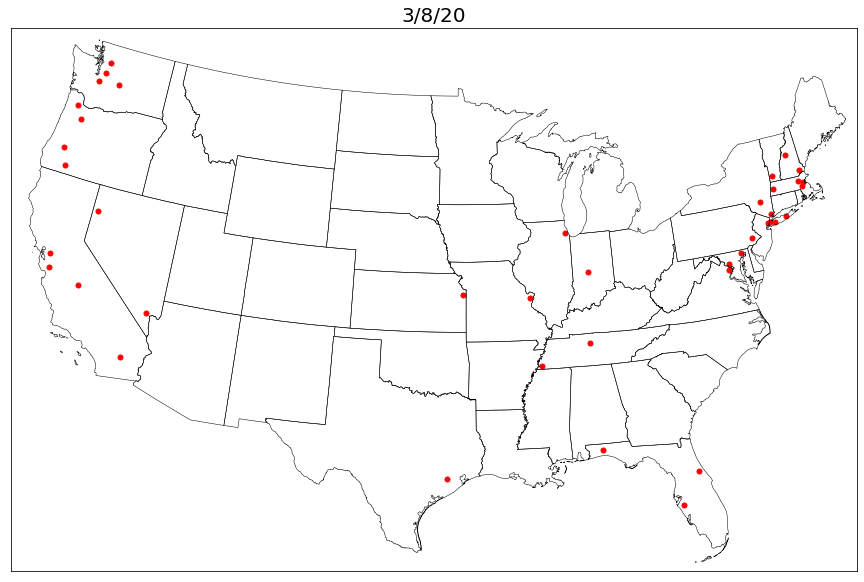

In [74]:
df_centroid = df_centroid[df_centroid.New_cases != 0]

df_centroid = df_centroid.reset_index(drop=True)

groupby_daily = df_centroid.groupby(df_centroid["Date"])

i = 0
g = None
for name, group in groupby_daily:
# 2174
    if len(group) == 41:
        fig = plt.figure(figsize=(16, 10))
        m_ = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
        m_.readshapefile('/content/drive/Shared drives/Stock_Covid_Data/COVID_19/st99_d00', name='states')
        df_comb_counties_distance = combinations_distance_df(group)
        G_t = pp.Network(directed=False)
        for index_group, row_group in group.iterrows():
            if row_group["New_cases"] >= 0:
                G_t.add_node(str(row_group["Combined_Key"]))
        m_.scatter(group["Long_"].tolist(), group["Lat"].tolist(), latlon=True, s=25, c="red", marker='o')    
        for index, row in df_comb_counties_distance.iterrows():
            if row["Distance"] < 100:
                tuple_county = row["Combinations"]
                if str(tuple_county[0]) in G_t.nodes and str(tuple_county[1]) in G_t.nodes:
                    G_t.add_edge(str(tuple_county[0]), str(tuple_county[1]))
        plt.title(str(name), fontsize=20)
        
        g = G_t
#         print(name)


#         pp.visualisation.plot(G_t)    
    # print(len(group))
        
style = {'width': 1000, 
          'height': 1000
        }
pp.visualisation.export_html(g, 'my_temporal_network.html')
pp.visualisation.plot(g,**style)

## Computing Stock paramaters - Abnormal price and Volatality:

In [ ]:
def stock_params(df_stock_data):
  # splitting stock data as pre-covid and covid
  mask = (df_stock_data['Date'] >= '2015-10-26') & (df_stock_data['Date'] <= '2020-01-21')
  historical_stock_data = df_stock_data.loc[mask]

  mask = (df_stock_data['Date'] > '2020-01-21') & (df_stock_data['Date'] <= '2020-07-27') #135 days excluding weekends - 188 days including
  covid_stock_data =  df_stock_data.loc[mask]
  covid_closing_prices = covid_stock_data.iloc[:, lambda df: [1,3,5]]
  
  print("P_t")
  print(covid_closing_prices)

  # compute the average price between 2015-10-26 and 2020-01-21
  history_closing_prices = historical_stock_data.iloc[:, lambda df: [1,3,5]]
  history_total = history_closing_prices.sum()
  avg_history_total = history_total.div(1066)

  print("P_t-i")
  print(avg_history_total)

  # compute standard deviation
  diff = history_closing_prices - [avg_history_total[0], avg_history_total[1], avg_history_total[2]]
  sd_stock_indices = (diff**2 / 1066)**0.5

  print("sigma_P")
  print(sd_stock_indices)


  return historical_stock_data,covid_stock_data


In [ ]:
historical_stock_data,covid_stock_data = stock_params(df_stock_data)
# print(historical_stock_data)
# print(covid_stock_data)

In [ ]:
covid_stock_data

In [ ]:
historical_stock_data